# Classification of Faces

In this excercise, we try to classify images of : "Miranda_Cosgrove" "Chris_Martin" "Emma_Stone" "Jamie_Foxx" "Steve_Jobs" "Zac_Efron" "Sandra_Oh" "Taryn_Manning". The data is from a random sample of 8 persons of the OXFORD VGG Face dataset, more information here: http://www.robots.ox.ac.uk/~vgg/data/vgg_face/.

## Downloading of Data

You can download the data using the following code:

In [74]:
import gzip
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.callbacks import LearningRateScheduler
from keras.optimizers import Adam
from keras.regularizers import l2

In [75]:
# Downloading the data, if it does not exist, this will take some time... (>120MB)
import urllib
import os
if not os.path.isfile('8_faces_train_and_valid.hdf5'):
    urllib.request.urlretrieve("https://www.dropbox.com/s/dx03vk6dmbtoywn/8_faces_train_and_valid.hdf5?dl=1","8_faces_train_and_valid.hdf5")

In [76]:
import h5py
h5f_X = h5py.File('8_faces_train_and_valid.hdf5', 'r')
print(h5f_X.keys())

print(h5f_X["X_train_8_faces"])

X_train = h5f_X['X_train_8_faces'][:]
print(X_train.shape)
print(X_train[0][0])
Y_train = h5f_X['Y_train_8_faces'][:]
print(Y_train.shape)
X_valid = h5f_X['X_valid_8_faces'][:]
print(X_valid.shape)
Y_valid = h5f_X['Y_valid_8_faces'][:]
print(Y_valid.shape, X_valid.dtype)

<KeysViewHDF5 ['X_train_8_faces', 'X_valid_8_faces', 'Y_train_8_faces', 'Y_valid_8_faces']>
<HDF5 dataset "X_train_8_faces": shape (2000, 48, 48, 3), type "<f8">
(2000, 48, 48, 3)
[[14. 17. 42.]
 [14. 17. 41.]
 [13. 18. 42.]
 [14. 18. 41.]
 [14. 18. 40.]
 [13. 17. 41.]
 [14. 17. 39.]
 [14. 17. 40.]
 [13. 17. 39.]
 [13. 17. 39.]
 [13. 17. 39.]
 [14. 16. 39.]
 [13. 16. 38.]
 [12. 15. 35.]
 [12. 15. 35.]
 [12. 15. 36.]
 [12. 15. 36.]
 [12. 15. 35.]
 [12. 15. 35.]
 [12. 15. 35.]
 [13. 15. 35.]
 [13. 15. 34.]
 [13. 15. 34.]
 [12. 15. 34.]
 [12. 14. 34.]
 [12. 15. 33.]
 [11. 15. 34.]
 [12. 14. 33.]
 [11. 14. 32.]
 [12. 14. 34.]
 [12. 14. 35.]
 [12. 14. 37.]
 [13. 15. 41.]
 [13. 15. 46.]
 [13. 15. 49.]
 [13. 15. 51.]
 [13. 16. 52.]
 [13. 16. 52.]
 [14. 16. 52.]
 [14. 17. 53.]
 [16. 18. 54.]
 [18. 19. 55.]
 [17. 19. 54.]
 [17. 19. 53.]
 [17. 19. 53.]
 [17. 19. 51.]
 [17. 18. 51.]
 [16. 18. 50.]]
(2000,)
(400, 48, 48, 3)
(400,) float64


250


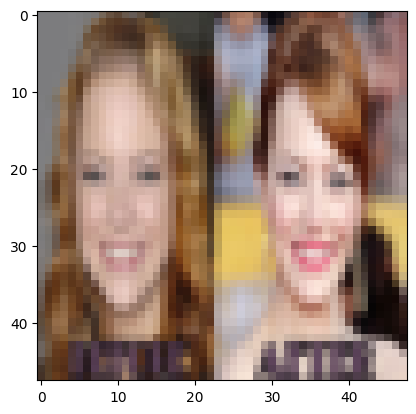

In [77]:
n = 0 #Miranda Cosgrove
n = 1 #Chris Martin (singer)
n = 2 #Emma Stone (actress)
n = 3 #Jamie Foxx (actor)
n = 4 #Steve Jobs (entrepreneur)
n = 5 #Zac Efron (actor)
n = 6 #Sandra Oh (actress)
n = 7 #Taryn Manning (actress)
n = 2
idx=np.reshape(np.where(Y_train[0:len(Y_train)]==n),(250))
print(len(Y_train[idx]))
plt.imshow(np.asarray(X_train[idx][0],dtype="uint8"))

In [78]:
#Downloading the data, if it does not exist
if not os.path.isfile('8_faces_test.hdf5'):
  urllib.request.urlretrieve("https://www.dropbox.com/s/ugxrdo0lpc2ixvr/8_faces_test.hdf5?dl=1","8_faces_test.hdf5")
h5f_X = h5py.File('8_faces_test.hdf5', 'r')
print(list(h5f_X.keys()))
X_test = h5f_X['X_test_8_faces'][:]
print(X_test.shape)
Y_test = h5f_X['Y_test_8_faces'][:]
print(Y_test.shape)

['X_test_8_faces', 'Y_test_8_faces']
(400, 48, 48, 3)
(400,)


In [79]:
np.min(X_train),np.max(X_train),np.min(X_test),np.max(X_test)
X_train /= 255
X_valid /= 255
X_test /= 255

## a) Training an CNN from scratch

Train a model (as shown below) from scratch, using the training data for training and the validation data for validation. For all activations in the hidden layer use the 'ReLU', for the last layer use softmax. Use 3x3 convolutions and use padding = same.

* Plot the learning curves: (epochs vs training loss and validation loss) and epochs vs accuracy. 
* Calculate the accuracy on the test set (you should reach an accuracy of about 0.54)
* Calculate the confusion matrix
* Have a look at missclassified examples

Image of the network:
https://github.com/ioskn/mldl_htwg/blob/master/uebungen/dl_cnn_faces_net.png

In [80]:
# Define our new model
# Same means "Zero Padding!"
model = Sequential()
model.add(Conv2D(15, (3, 3), input_shape=(48, 48, 3), name='conv2d_4', padding="same", activation="relu"))
model.add(Conv2D(15, (3, 3), input_shape=(48, 48, 3), name='conv2d_5', padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2), name='max_pooling2d_2', padding="same"))
model.add(Conv2D(30, (3, 3), input_shape=(24, 24, 3), name='conv2d_6', padding="same", activation="relu"))
model.add(Conv2D(30, (3, 3), input_shape=(24, 24, 3), name='conv2d_7', padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2), name='max_pooling2d_3', padding="same"))
model.add(Flatten(name='flatten_2'))
model.add(Dense(300, activation='relu', name='dense_2'))
model.add(Dropout(0.2, name="dropout"))
model.add(Dense(8, activation='softmax', name='dense_3'))

# Compile it
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


# Train it
history = model.fit(X_train, Y_train, epochs=10, validation_data=(X_valid, Y_valid))


Epoch 1/10
63/63 [==============================] - 5s 63ms/step - loss: 1.9237 - accuracy: 0.2435 - val_loss: 1.6642 - val_accuracy: 0.4275
Epoch 2/10
63/63 [==============================] - 4s 60ms/step - loss: 1.4964 - accuracy: 0.4620 - val_loss: 1.3863 - val_accuracy: 0.5150
Epoch 3/10
63/63 [==============================] - 4s 63ms/step - loss: 1.1909 - accuracy: 0.5840 - val_loss: 1.2428 - val_accuracy: 0.5850
Epoch 4/10
63/63 [==============================] - 4s 59ms/step - loss: 0.9164 - accuracy: 0.6880 - val_loss: 1.3114 - val_accuracy: 0.5400
Epoch 5/10
63/63 [==============================] - 4s 57ms/step - loss: 0.7267 - accuracy: 0.7460 - val_loss: 1.3388 - val_accuracy: 0.5775
Epoch 6/10
63/63 [==============================] - 4s 56ms/step - loss: 0.5050 - accuracy: 0.8240 - val_loss: 1.3283 - val_accuracy: 0.6300
Epoch 7/10
63/63 [==============================] - 4s 59ms/step - loss: 0.3291 - accuracy: 0.8840 - val_loss: 1.3090 - val_accuracy: 0.6350
Epoch 8/10
63

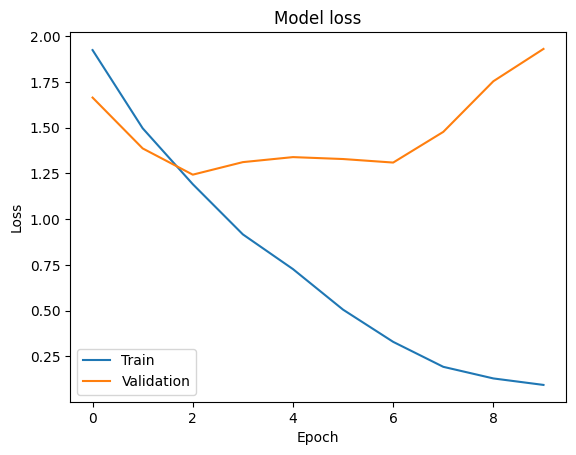

In [81]:
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

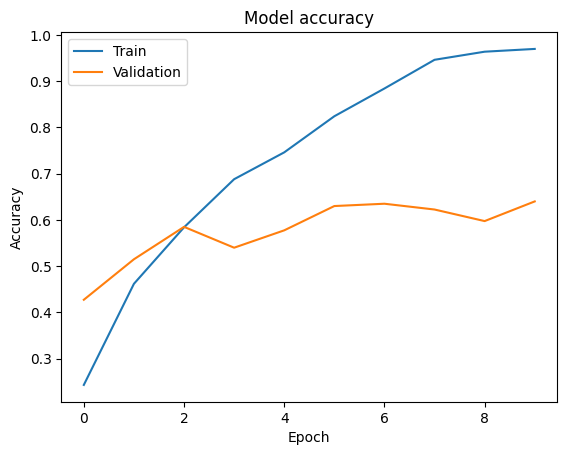

In [82]:
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## b) Training using transfer learning
In transfer learning you use an existing trained model with given weights trained on a different task. You then add a few layers yourself and only train them. The model you add should look like:

```
my_dense1 (Dense)            (None, 512)               262656    
_________________________________________________________________
my_dense2 (Dense)            (None, 512)               262656    
_________________________________________________________________
my_dense3 (Dense)            (None, 100)               51300     
_________________________________________________________________
my_dense4 (Dense)            (None, 8)                 808       
```

Use the following code as a starting point:

In [83]:
from keras.applications import VGG16
img_height = img_width = 48
base_model = VGG16(weights='imagenet', include_top=False,input_shape = (img_width, img_height, 3))

In [84]:
fc1 = base_model.output
fc1 = Flatten()(fc1)
fc1 = Dense(512, activation="relu", name="my_dense1")(fc1)
fc1 = Dense(512, activation="relu", name="my_dense2")(fc1)
fc1 = Dense(512, activation="relu", name="my_dense3")(fc1)
fc1 = Dense(8,activation='softmax', name='my_dense4')(fc1)
model_trans = tf.compat.v1.keras.Model(base_model.input, fc1) #Current hack for TF 2.0 and keras
model_trans.summary()

Model: "model_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0  

In [85]:
#base_model.summary()
for layer in model_trans.layers:
  name = layer.name
  if name.startswith('my'):
    layer.trainable = True
    print(name)
  else:
    layer.trainable = False

my_dense1
my_dense2
my_dense3
my_dense4


In [86]:
# Compile transfer model
model_trans.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# And train
history_trans = model_trans.fit(X_train, Y_train, epochs=10, validation_data=(X_valid, Y_valid))

Epoch 1/10
63/63 [==============================] - 12s 175ms/step - loss: 1.6704 - accuracy: 0.3720 - val_loss: 1.3567 - val_accuracy: 0.5200
Epoch 2/10
63/63 [==============================] - 10s 156ms/step - loss: 1.2272 - accuracy: 0.5515 - val_loss: 1.3773 - val_accuracy: 0.5375
Epoch 3/10
63/63 [==============================] - 10s 158ms/step - loss: 0.9949 - accuracy: 0.6420 - val_loss: 1.3502 - val_accuracy: 0.5775
Epoch 4/10
63/63 [==============================] - 10s 159ms/step - loss: 0.7934 - accuracy: 0.7160 - val_loss: 1.4889 - val_accuracy: 0.5275
Epoch 5/10
63/63 [==============================] - 10s 161ms/step - loss: 0.6137 - accuracy: 0.7870 - val_loss: 1.4668 - val_accuracy: 0.5575
Epoch 6/10
63/63 [==============================] - 10s 159ms/step - loss: 0.4816 - accuracy: 0.8300 - val_loss: 1.4927 - val_accuracy: 0.5475
Epoch 7/10
63/63 [==============================] - 10s 158ms/step - loss: 0.3982 - accuracy: 0.8535 - val_loss: 1.5297 - val_accuracy: 0.5975

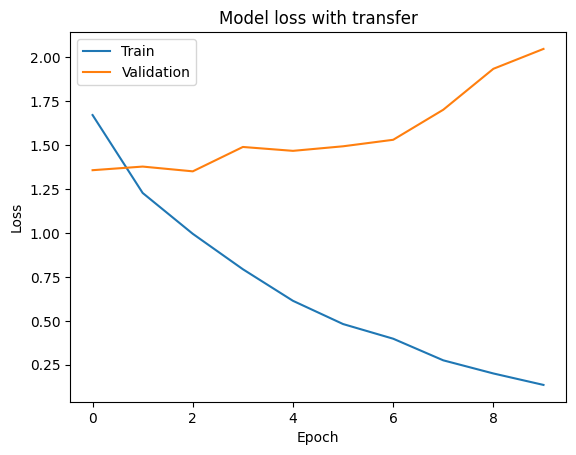

In [87]:
plt.plot(history_trans.history['loss'], label='Train')
plt.plot(history_trans.history['val_loss'], label='Validation')
plt.title('Model loss with transfer')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

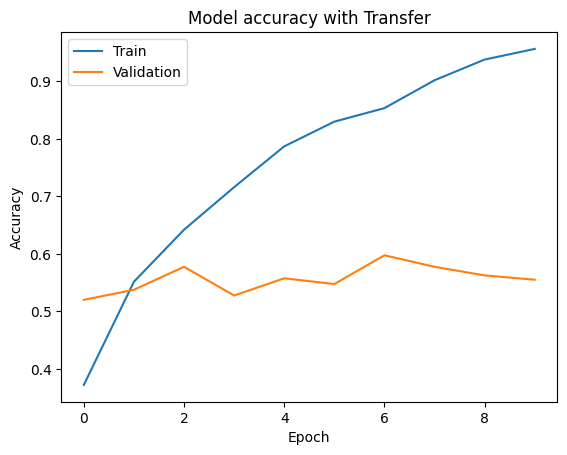

In [88]:
plt.plot(history_trans.history['accuracy'], label='Train')
plt.plot(history_trans.history['val_accuracy'], label='Validation')
plt.title('Model accuracy with Transfer')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Do the same analysis as in a) above. You should get an accuracy of approx 0.61

## c) Try to get better.

Ideas: use dropout and other tricks to prevent overfitting. Try to learn some convulutional layers as well.

In [89]:
# Create an ImageDataGenerator for data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.1,
    zoom_range=0.25,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [94]:
fc2 = base_model.output

#======== Model to play around and improve ==============================================
# TODO - Shall we actually play around with the model from transfer or our own?
# Alex: - Tried adding dropouts with regularizer
fc2 = Flatten(name="my_flatten")(fc2)

fc2 = Dense(512, activation="relu", name="my_dense1", kernel_regularizer=l2(0.001))(fc2)
fc2 = Dropout(0.1, name="my_dropout3")(fc2)
#fc2 = BatchNormalization(name="my_batch_norm3")(fc2)

fc2 = Dense(512, activation="relu", name="my_dense2", kernel_regularizer=l2(0.001))(fc2)
fc2 = Dropout(0.1, name="my_dropout4")(fc2)
#fc2 = BatchNormalization(name="my_batch_norm4")(fc2)

fc2 = Dense(512, activation="relu", name="my_dense3")(fc2)
fc2 = Dense(8,activation='softmax', name='my_dense4')(fc2)

model_better = tf.compat.v1.keras.Model(base_model.input, fc2)
#model_better.summary()

#========================================================================================

# Just as above
for layer in model_better.layers:
  name = layer.name
  if name.startswith('my'):
    layer.trainable = True
  else:
    layer.trainable = False


# Compile improved model
model_better.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train
#history_better = model_better.fit(
#    datagen.flow(X_train, Y_train, batch_size=100),
#    epochs=10,
#    validation_data=(X_valid, Y_valid)
#)

history_better = model_better.fit(X_train, Y_train, epochs=10, validation_data=(X_valid, Y_valid))

Epoch 1/10
20/20 [==============================] - 19s 904ms/step - loss: 1.9512 - accuracy: 0.2330 - val_loss: 1.7456 - val_accuracy: 0.3275
Epoch 2/10
20/20 [==============================] - 18s 889ms/step - loss: 1.7071 - accuracy: 0.3730 - val_loss: 1.5664 - val_accuracy: 0.4250
Epoch 3/10
20/20 [==============================] - 18s 897ms/step - loss: 1.5755 - accuracy: 0.4180 - val_loss: 1.3910 - val_accuracy: 0.5025
Epoch 4/10
20/20 [==============================] - 18s 889ms/step - loss: 1.4688 - accuracy: 0.4595 - val_loss: 1.3880 - val_accuracy: 0.4575
Epoch 5/10
20/20 [==============================] - ETA: 0s - loss: 1.4264 - accuracy: 0.4665

KeyboardInterrupt: 

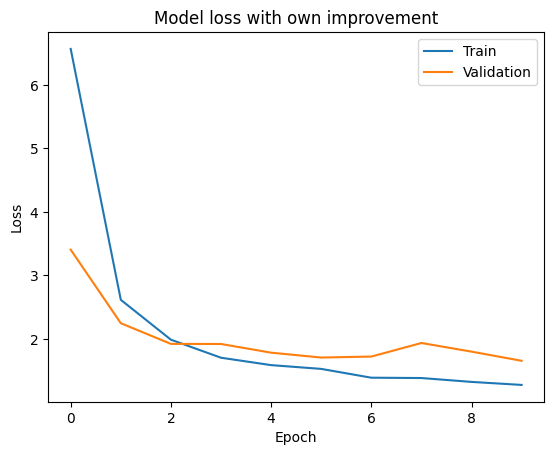

In [ ]:
plt.plot(history_better.history['loss'], label='Train')
plt.plot(history_better.history['val_loss'], label='Validation')
plt.title('Model loss with own improvement')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

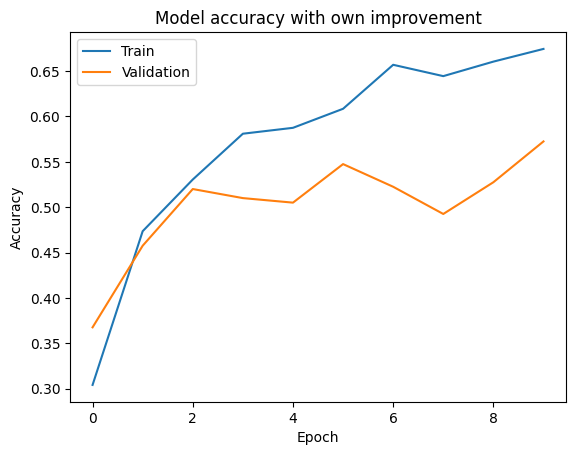

In [ ]:
plt.plot(history_better.history['accuracy'], label='Train')
plt.plot(history_better.history['val_accuracy'], label='Validation')
plt.title('Model accuracy with own improvement')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()